# Dask
Dask stands as a highly adaptable and potent Python library, purposefully crafted to address the challenges of parallel computing. <a href="https://docs.dask.org/en/stable/" target="_blank">link</a>

The framework of Dask encompasses two fundamental pillars, each contributing to its robust capabilities:

1. **Dynamic Task Scheduling for Optimized Computation**: Dask excels in the realm of dynamic task scheduling, a strategic approach to orchestrating computational processes. Analogous to renowned tools like Airflow, Luigi, Celery, and Make, Dask's distinction emerges in its meticulous calibration for interactive computational workloads. This entails efficiently managing and distributing tasks in real-time, thereby streamlining the execution of complex computational workflows.

2. **Parallel Data Structures for Scaling "Big Data"**: Dask introduces an array of sophisticated data structures tailored to tackle the intricacies of handling voluminous datasets, often referred to as "Big Data." These parallel collections encompass arrays, dataframes, and lists, ingeniously designed to extend the functionality of widely-used interfaces like NumPy, Pandas, and Python iterators. Their remarkable attribute lies in their innate ability to seamlessly transition across memory boundaries and even operate within distributed computing environments. Notably, these parallel collections are intricately interwoven with the dynamic task schedulers, ensuring a harmonious fusion of efficient computation and data management.

# Excersize 1: from pandas to dask DataFrame
I will use 'ipynb' format for this excersize since I want to get familiar with 'dask' library and also the dataset.

In [1]:
import os
import re
import math
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import time
import joblib
import numpy as np
import dask.dataframe as dd
from dask_ml import linear_model
from dask_ml import preprocessing
from dask_ml import model_selection
from dask.distributed import Client
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification, make_moons
from sklearn.metrics import accuracy_score

Now, we need to setup a local cluster for Dask to work with. The relevant code is repeated below.

In [2]:
# Make your client
client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 15.89 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52749,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.89 GiB
Comm: tcp://127.0.0.1:52769,Total threads: 2
Dashboard: http://127.0.0.1:52772/status,Memory: 3.97 GiB
Nanny: tcp://127.0.0.1:52752,


Here I first load the data and present some of its features.

In [3]:
#inspired by https://fennaf.gitbook.io/bfvm22prog1/data-processing/configuration-files/yaml

def configReader():
    """
    explanation: This function open config,yaml file 
    and fetch the gonfigue file information
    input: ...
    output: configue file
    """
    with open("config.yaml", "r") as inputFile:
        config = yaml.safe_load(inputFile)
    return config

In [4]:
def dataframe_maker(config):
    # Open file directory and change the direction
    file_directory, main_directory = config.values()
    os.chdir(file_directory)

    # make a dictionary from datasets
    ddf_dict = { f'199{number}': dd.read_csv(f"{file_directory}\{file}") 
                for number, file in enumerate(os.listdir())}

    # make a whle dataset from all the data files
    ddf = dd.read_csv(
    os.path.join(file_directory, "*.csv"), parse_dates={"Date": [0, 1, 2]})   

    return ddf_dict, ddf

In [5]:
# make the dataset and data dictionary
ddf_dict, ddf = dataframe_maker(configReader())

In [6]:
ddf

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,string,int64,float64,float64,int64,float64,float64,float64,string,string,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Dask has not yet fetched the actual data; instead, it has performed the following steps:

1. Explored the provided input path and identified ten corresponding files.
2. Cleverly formulated a set of tasks for every data chunk, with each task being associated with an original CSV file in this instance.

It's important to note that the DataFrame object's representation doesn't encompass any actual data at this point. Dask has executed adequate operations to initiate reading from the outset of the initial file. This has enabled it to deduce the column names and data types, contributing to a preliminary understanding of the data structure.

In [7]:
ddf.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [ ]:
ddf.tail()

ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+----------------+---------+----------+
| Column         | Found   | Expected |
+----------------+---------+----------+
| CRSElapsedTime | float64 | int64    |
| TailNum        | object  | float64  |
+----------------+---------+----------+

The following columns also raised exceptions on conversion:

- TailNum
  ValueError("could not convert string to float: 'N54711'")

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'CRSElapsedTime': 'float64',
       'TailNum': 'object'}

to the call to `read_csv`/`read_table`.

In contrast to the behavior of pandas.read_csv, which involves reading the entire file prior to inferring data types, the dask.dataframe.read_csv function takes a different approach. It selectively reads a sample from the file's beginning (or the first file, when employing a glob pattern). This method efficiently streamlines the process, allowing for quicker and more resource-conscious data type inference. Consequently, the program can detect some the data types incorrectly especially when there is no value for that feature in the few first samples of the dataset. To tackle this problem, a few approaches can be implemented. I will implement the least error-prone one. For this purpose, I need to change 'dataframe_maker' function.

In [4]:
def dataframe_maker_corrected(config):
    # Open file directory and change the direction
    file_directory, main_directory = config.values()
    os.chdir(file_directory)

    # make a dictionary from datasets
    ddf_dict = { f'199{number}': dd.read_csv(f"{file_directory}\{file}") 
                for number, file in enumerate(os.listdir())}

    # make a whle dataset from all the data files
    ddf = dd.read_csv(
    os.path.join(file_directory, "*.csv"),
    parse_dates={"Date": [0, 1, 2]},
    dtype={"TailNum": str, "CRSElapsedTime": float, "Cancelled": bool},
    )

    return ddf_dict, ddf

In [5]:
ddf_dict, ddf = dataframe_maker_corrected(configReader())

In [6]:
ddf.tail()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999-12-27,1,1645.0,1645,1830.0,1901,UA,1753,N516UA,225.0,...,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,False,0
269177,1999-12-28,2,1726.0,1645,1928.0,1901,UA,1753,N504UA,242.0,...,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,False,0
269178,1999-12-29,3,1646.0,1645,1846.0,1901,UA,1753,N592UA,240.0,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,False,0
269179,1999-12-30,4,1651.0,1645,1908.0,1901,UA,1753,N575UA,257.0,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,False,0
269180,1999-12-31,5,1642.0,1645,1851.0,1901,UA,1753,N539UA,249.0,...,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,False,0


One can see that it works. Now, I will anwer to the questions of the first excersize.

1. In total, how many non-canceled flights were taken from each airport?

In [7]:
ddf.columns

Index(['Date', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime',
       'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime',
       'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest',
       'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'Diverted'],
      dtype='object')

To answer this question, one should count the number of True items in 'cancelled' column:

In [54]:
cancelled_flights = ddf.Cancelled.value_counts().compute()
cancelled_flights

Cancelled
False    2540961
True       70931
Name: count, dtype: int64

In [55]:
cancelled_flights[cancelled_flights.index==False]

Cancelled
False    2540961
Name: count, dtype: int64

It shows that 2540961 flights had not been canclled during the mentioned period of time. But from each airport:

In [61]:
cancelled_number = ddf.groupby("Origin").Cancelled.value_counts().compute()

# Filter the result to keep only the rows where "Cancelled" is False
cancelled_number[cancelled_number.index.get_level_values("Cancelled")==False]

Origin  Cancelled
EWR     False        1139451
JFK     False         427243
LGA     False         974267
Name: count, dtype: int64

EWR has the largest number of non-cancelled flight.

2. What was the average departure delay from each airport?

In [25]:
# Groupby 'Origin' first then make an average on 'DepDelay'
ddf.groupby('Origin').DepDelay.mean().compute()

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

This shows that JFK (John. F. Kenedy) airport has the largest departure delay time.

3. Per airport, what day of the week has the worst average departure delay?

In [83]:
departure_delay_day = ddf.groupby(['Origin','DayOfWeek']).DepDelay.mean().compute()

# Again groupby 'Origin' to give the index per airport and find the maximum mean values
departure_delay_day.groupby('Origin').idxmax()

Origin
EWR    (EWR, 5)
JFK    (JFK, 5)
LGA    (LGA, 5)
Name: DepDelay, dtype: object

Day 5 has the worst average departure delay for all the airports.

4. What are the busiest hours?

The term "Busiest Hours" can encompass various interpretations, making it a challenge to precisely define. One way to approach this concept is by considering the count of departure flights from an airport as well as the count of arriving flights to that same airport, both on an hourly basis. However, it's important to note that the count of arriving flights tends to be comparatively smaller than the count of departures. As a result, I will focus my analysis primarily on the count of departure flights for the sake of clarity and practicality.

In [96]:
# claculate the number of 'arrived' flight into 'EWR', 'JFK', and 'LGA' airports.
airports = ['EWR', 'JFK', 'LGA']
arrived_flights = ddf.Dest.value_counts().compute()
arrived_flights[airports]

Dest
EWR    31
JFK     6
LGA     8
Name: count, dtype: int64[pyarrow]

So, the number of arrived flights for these three airports are quite small in comparison to their departure flights.

In [114]:
departure_time = ddf.groupby('Origin').CRSDepTime.value_counts().compute()
departure_time.groupby('Origin').idxmax()

Origin
EWR    (EWR, 700)
JFK    (JFK, 800)
LGA    (LGA, 830)
Name: count, dtype: object

It shows that  seven to eight AM are the busiest hours of these airports. One can sum over the departures that are in the same hour, but I will not do this here.

# Exercise 2: Dask_ML
First making another client

In [2]:
# Make your client
client = Client(n_workers=10)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 10,Total memory: 15.89 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49781,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 15.89 GiB
Comm: tcp://127.0.0.1:49848,Total threads: 1
Dashboard: http://127.0.0.1:49849/status,Memory: 1.59 GiB
Nanny: tcp://127.0.0.1:49784,


First, I would like to run the model that our teacher uploaded on the site.

In [21]:
# Make the dataset and split it into train\test datasets
X, y = make_classification(n_samples=1000, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Make list of parameters
param_grid = {"C": [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
              "kernel": ['rbf', 'poly', 'sigmoid'],
              "shrinking": [True, False]}

# make GridSearchCV item and train it
grid_search = GridSearchCV(SVC(gamma='auto', random_state=0, probability=True),
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

# print the best estimator set
grid_search.best_estimator_

In [22]:
y_predict = grid_search.predict(X_test)

print(f'the accuracy of the model is {accuracy_score(y_test, y_predict)}')

the accuracy of the model is 0.956


The accuracy is pretty acceptable for this model.

now I am using dask to run this program again, and see whether the time duration is shorter. 

In [6]:
with joblib.parallel_backend('dask'):
    # Make the dataset and split it into train\test datasets
    X, y = make_classification(n_samples=1000, random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # Make list of parameters
    param_grid = {"C": [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
              "kernel": ['rbf', 'poly', 'sigmoid'],
              "shrinking": [True, False]}

    # make GridSearchCV item and train it
    grid_search = GridSearchCV(SVC(),
                            param_grid=param_grid,
                            cv=3)

    grid_search.fit(X_train, y_train)

    # print the best estimator set
    grid_search.best_estimator_

In [7]:
y_predict = grid_search.predict(X_test)

print(f'the accuracy of the model is {accuracy_score(y_test, y_predict)}')

the accuracy of the model is 0.96


The last part of this Assignment is to use dask_ml. As it is mentioned in the question, first, I will make the moon dataset, and the make two logistic regressors to predict the labels.

In [3]:
# Make the moon dataset and split it into train\test datasets
X, y = make_moons(n_samples=1000, noise=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

**sklearn model**

In [4]:
# make sklearn logistic regression

start = time.time()
# Create a pipeline with PolynomialFeatures and LogisticRegression
logistic_regression_pipeline = Pipeline([('polynomial', PolynomialFeatures()),
                                         ('LogisticRegression', LogisticRegression())])

# Logitic Regression
lr_param = {'polynomial__degree': np.arange(2,10,1),
            'LogisticRegression__C':  np.arange(0.01, 10, 0.25),
            'LogisticRegression__penalty': ['l1', 'l2']}

# make GridSearchCV item and train it
grid_search = GridSearchCV(logistic_regression_pipeline,
                            param_grid=lr_param,
                            cv=5,
                            n_jobs=-1)

grid_search.fit(X_train, y_train)

end = time.time()
print(f'time: {end - start}')
# print the best estimator set
best_model_sklearn = grid_search.best_estimator_

time: 10.485623598098755


c:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1600 fits failed out of a total of 3200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1600 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Anaconda3\lib\site-p

In [5]:
y_predict = best_model_sklearn.predict(X_test)

print(f'the accuracy of the model is {accuracy_score(y_test, y_predict)}')

the accuracy of the model is 1.0


This model produce an incridble result of 100% accuracy just in 15 seconds.

**dask_ml model**
I have used GridSearchCV from this library but it performs quite poorly since it cannot handle errors stemmed from hyperparameter inconsistency. Consequently, It did not make a model when I used a pipeline for it. Also, it is quite slower than sklearn, especially when using only logistic regression function that takses around two minutes.

In [6]:
# make dask_ml logistic regression

start = time.time()

# Logitic Regression
lr_param = {
            'C':  np.arange(0.01, 10, 0.25),
            'penalty': ['l1', 'l2']
            }

# make GridSearchCV item and train it
grid_search = GridSearchCV(linear_model.LogisticRegression(),
                            param_grid=lr_param,
                            cv=5)

grid_search.fit(X_train, y_train)

end = time.time()
print(f'time: {end - start}')
# print the best estimator set
best_model_dask = grid_search.best_estimator_

time: 110.62523198127747


In [7]:
y_predict = best_model_dask.predict(X_test)

print(f'the accuracy of the model is {accuracy_score(y_test, y_predict)}')

the accuracy of the model is 0.9


It gives us 86% accuaracy which is a discepointing score for this model. But, itcould be predicted since we could not use polynomial preprcessing step before using logistic regression. 

I believe that sklearn yet is the best library to use for deep learning. It is fast, user-freindly, and take care of numerous number of internal errors.

last part making cantours:

In [8]:
def make_meshgrid(X, h=.01):
    """
    Create a mesh grid based on vectors X and Y. This meshgrid will 
    used in some visualizations such as vontour plots
    """
    if X.shape[1] > 2:
        raise ValueError('Requires a matrix of 2 features for visualization purposes.')
    
    x_min = X.min() - 1
    x_max = X.max() + 1
        
    x = np.arange(x_min, x_max, h)
    
    # Return a list of coordinate matrices from coordinate vectors.
    xx, yy = np.meshgrid(x, x)
    
    return xx, yy

In [9]:
def making_contour(model_dict, title):

    plots_number = len(model_dict)

    num_cols = math.ceil(math.sqrt(plots_number))
    num_rows = math.ceil(plots_number / num_cols)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10,7))

    if len(title)!=0:
        fig.suptitle(title)

    if len(model_dict) > 1:
        # flatten for easier manipulation
        axes.ravel()
    else:
        axes = [axes]

    for counter, key in enumerate(model_dict):
        data_dict = model_dict[key][-1]

        contour = axes[counter].contourf(data_dict['xx'], data_dict['yy'], model_dict[key][0],
                                          25, cmap=plt.cm.RdBu, alpha=0.8)

        # add the color bar for logestic regression
        if re.search(r'lo.*r', key, re.IGNORECASE):
            
            ax_c = fig.colorbar(contour, location='bottom', fraction=0.02)
            ax_c.set_label('$P(y = 1)$')
            ax_c.set_ticks([0, .25, .5, .75, 1])
        
        # add desicion boundary to svm contour
        elif re.search(r'sv', key, re.IGNORECASE):
            axes[counter].contour(data_dict['xx'], data_dict['yy'], model_dict[key][1], colors='k', levels=[-1, 0, 1],
                                   alpha=0.5, linestyles=['--', '-', '--'])

        # plot the test data
        axes[counter].scatter(data_dict['x_test'][:, 0], data_dict['x_test'][:, 1], c=data_dict['y_test'],
                               edgecolor='white', linewidth=1, s=50, cmap=plt.cm.RdBu)

        # set some labels
        axes[counter].set(aspect='equal',
                          xlim=(data_dict['X'].min() - 1, data_dict['X'].max() + 1),
                          ylim=(data_dict['X'].min() - 1, data_dict['X'].max() + 1),
                          xlabel='$X_1$',
                          ylabel='$X_2$')
        
        axes[counter].set_title(f'{key} model')
    
    plt.show()

In [10]:
# make the meshgrid 
xx, yy = make_meshgrid(X)

#--------------------------------------
# np.array.ravel(): returns contiguous flattened array(1D array with all the input-array 
#                   elements and with the same type as it).
#  np.c_: add along second axis.
#--------------------------------------

# make the grid
grid = np.c_[xx.ravel(), yy.ravel()] 

In [11]:
lr_prob_sklearn = best_model_sklearn.predict_proba(grid)[:, 1].reshape(xx.shape)
lr_prob_dask = best_model_dask.predict_proba(grid)[:, 1].reshape(xx.shape)

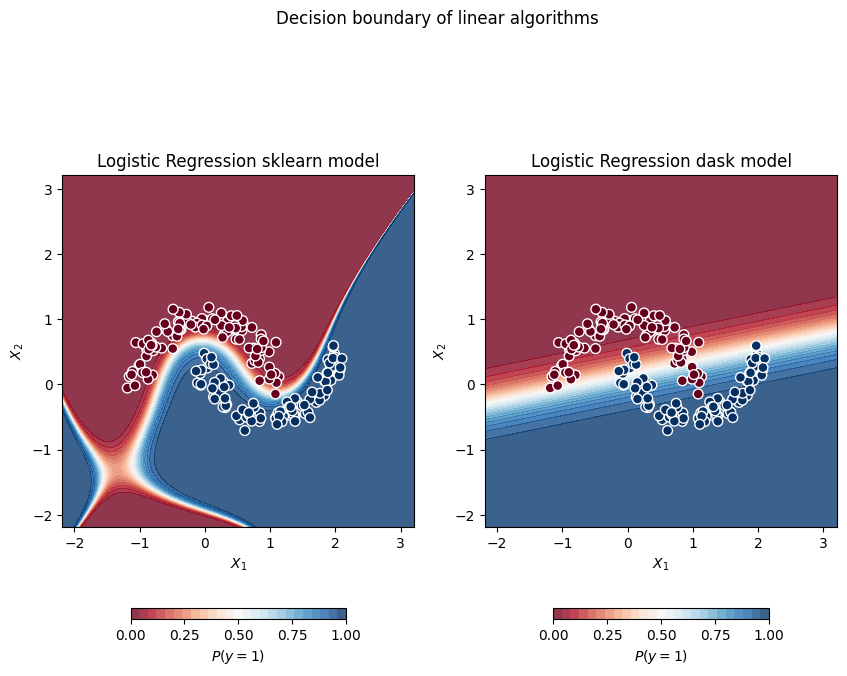

In [13]:
# make the contour plot
data_dict = {'X': X,
             'xx':xx,
             'yy':yy,
             'x_test':X_test,
             'y_test':y_test
             }
model_dict= {'Logistic Regression sklearn':[lr_prob_sklearn, data_dict],
             'Logistic Regression dask':[lr_prob_dask, data_dict]}

title = 'Decision boundary of linear algorithms'

making_contour(model_dict, title)